In [1]:
## conda requirements (with tested python version)
# !conda install --file ../env/byoml_sklearn_24/environment.yml
# !conda activate byoml_sklearn 
# !pip install -r ../env/byoml_sklearn_24/requirements.txt
### above install can also be done with script 
# bin/conda_create env/byoml_sklearn_24

## ALT pip-only requirements:
# !pip install waylay-beta[byoml-sklearn-0.24]


In [2]:
from datetime import datetime
from random import random
run_id = f"{datetime.now():%Y-%m-%d}-{1000 * random():04.0f}"
MODEL_NAME=f'tutorial-{run_id}'
PROFILE='render_notebook'
MODEL_NAME

'tutorial-2023-06-01-0781'

In this notebook we will show how you can integrate a scikit-learn model with our platform. We will make use of our Python SDK, which you can install by executing (using the additional libraries for `[scikit-learn-0.24]`)

`pip install waylay-beta[byoml-sklearn-0.24]`

(See https://docs.waylay.io/#/api/sdk/python?id=byoml-optional-installs for available options)

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:59:23) \n[Clang 11.1.0 ]'

## Generated dataset

First let's create a dataset generator for a temperature and light sensor consisting of 
* three gaussian blobs with fixed sized around fixed centers 
* a uniform scattering of data, the candidate outliers. 

In [4]:
col_tmp = 'Temperature'
col_amb = 'Light Ambience'
col_src = 'Source'
col_features = [col_tmp, col_amb]

def generate_dataset(samples=300, outliers=0.1):
    blob_data =  make_blobs(
        centers=[[16, 0], [21, 1200], [19, 600]], 
        cluster_std=[[1, 0], [0.5, 150], [0.7, 180]], 
        n_features=2, 
        n_samples=samples
    )
    dataset_blob = pd.DataFrame(blob_data[0], columns=[col_tmp, col_amb])
    dataset_blob[col_src] = 'blob'

    outlier_count = int(outliers * samples)
    outlier_data = np.random.uniform(low=[13, 0], high=[24, 2000], size=(outlier_count,2))
    dataset_outliers = pd.DataFrame(outlier_data, columns=[col_tmp, col_amb])
    dataset_outliers[col_src] = 'uniform'
    
    return dataset_blob.append(dataset_outliers, ignore_index=True).sample(n=samples)



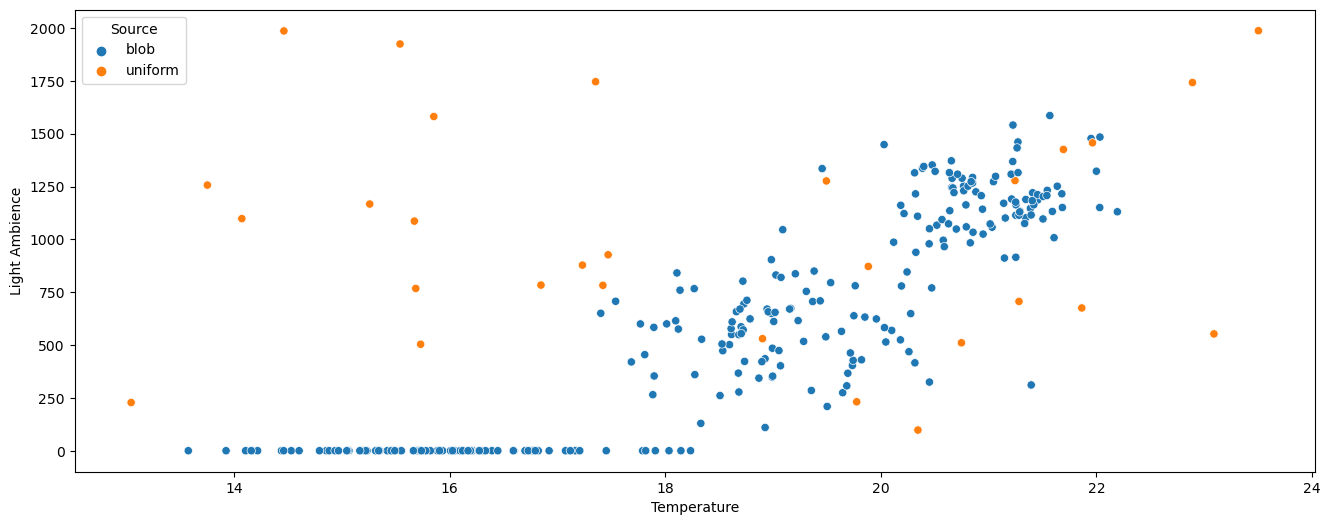

In [5]:
dataset_train = generate_dataset(outliers=0.1)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x=col_tmp, y=col_amb, hue=col_src, data=dataset_train)


## Create a model

In this example we will use an IsolationForest to detect outliers, for which later on alarms can be generated.

In [6]:
from sklearn.ensemble import IsolationForest

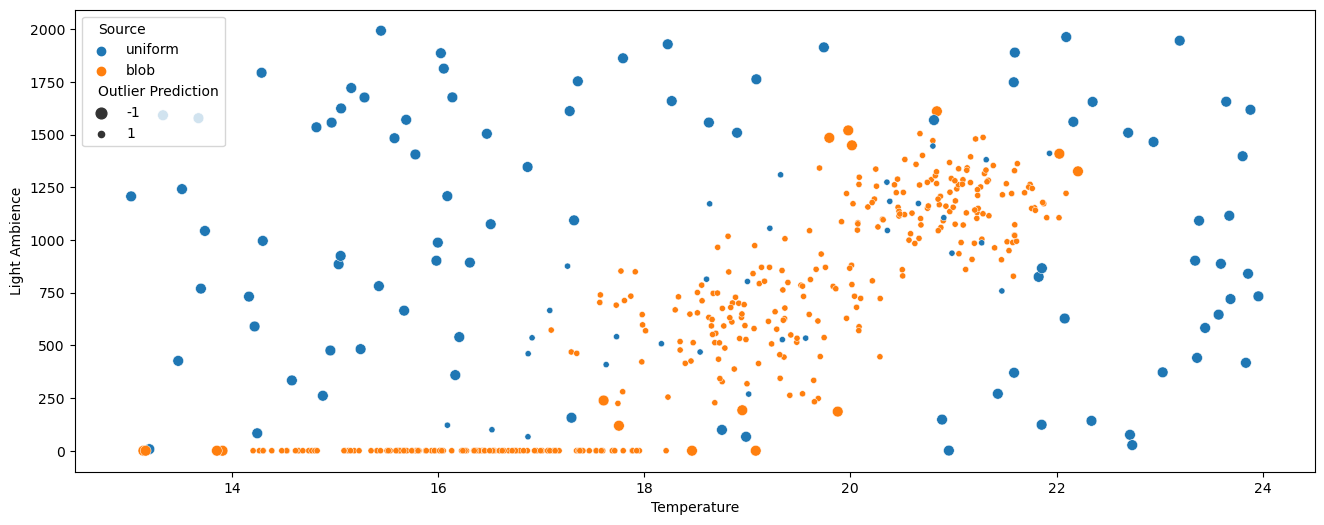

In [7]:
# we use the knowledge that 0.1 of the datapoints are expected to be outliers
model = IsolationForest(contamination=0.1)
model.fit(dataset_train[col_features])

# you could try other sample counts and outlier proportions here ...
dataset_validate = generate_dataset(samples=500, outliers=0.3)
col_predict = 'Outlier Prediction'
dataset_predict = dataset_validate.copy()
dataset_predict[col_predict] = model.predict(dataset_validate[col_features])

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb,
    hue=col_src, 
    size=col_predict, sizes=[60,20], 
    data=dataset_predict
)

Let's have a look of the performance of this model. 

The sklearn `confusion_matrix` will count expected predictions (whether the datapoint came from the _uniform_ or _blob_ distributions), with the actual classification by the model.

Of course we expect quite some _false negative_ classifications, where samples from the _uniform_ distribution happen to be consistent with the _blobs_.

In [8]:
def report(dataset_predict):
    expected = dataset_predict[col_src].map(lambda x: 1 if x=='blob' else -1)
    predicted = dataset_predict[col_predict]
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
    display(pd.DataFrame(
        confusion_matrix(expected, predicted),
        columns=['Detected', 'Not Detected'],
        index=['Uniform', 'Blob']
    ))
    display(pd.DataFrame(
        [
            precision_score(expected,predicted),
            recall_score(expected,predicted),
            f1_score(expected,predicted)
        ],
        columns=['Score'],
        index=['Precision', 'Recall', 'F1']
    ))

report(dataset_predict)

,Detected,Not Detected
Uniform,90,30
Blob,16,364


,Score
Precision,0.923858
Recall,0.957895
F1,0.940568


## Upload and test the model

When the model is ready, we can upload it to the platform. First we need to save it, afterwards we can use the SDK to upload and call it. 
When uploading the model we need to provide some basic information. Like:
- which framework: `sklearn`, `tensorflow`, `pytorch` or `xgboost`
- a name for the model
- the model file (or directory for TensorFlow models)
- an optional description

In [9]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile(PROFILE)

In [10]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'No model 'tutorial-2023-06-01-0781''; DELETE 'https://api.waylay.io/ml/v1/models/tutorial-2023-06-01-0781')"

In [11]:
waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2023-06-01-0781',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

In [12]:
waylay.byoml.model.get(MODEL_NAME)


{'createdBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'createdOn': '2023-06-01T10:26:49.464000+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2023-06-01-0781',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
 'updatedOn': '2023-06-01T10:27:14.570000+00:00',
 'version': '1'}

To validate that the local and uploaded model behave the same, we extract a small sample from training data set.

In [13]:
sample = dataset_train[dataset_train[col_src]=='blob'].iloc[0:3]
sample = sample.append(dataset_train[dataset_train[col_src]=='uniform'].iloc[0:3]) 
sample

,Temperature,Light Ambience,Source
289,20.948719,1024.888324,blob
100,20.215222,1121.929274,blob
277,18.596267,501.740244,blob
305,20.344156,97.808997,uniform
316,17.421910,782.519833,uniform
315,14.072730,1098.052143,uniform


Using sample data to test the local model

In [14]:
sample['Local Prediction'] = model.predict(sample[col_features])
sample

,Temperature,Light Ambience,Source,Local Prediction
289,20.948719,1024.888324,blob,1
100,20.215222,1121.929274,blob,1
277,18.596267,501.740244,blob,1
305,20.344156,97.808997,uniform,-1
316,17.421910,782.519833,uniform,1
315,14.072730,1098.052143,uniform,-1


The same using the model served by BYOML.

Note that it takes a few seconds to activate a new model. SDK actions such as `byoml.model.predict` will retry a few times until the model is ready.

In [15]:
sample['Byoml Prediction'] = waylay.byoml.model.predict(MODEL_NAME, sample[col_features])

sample

,Temperature,Light Ambience,Source,Local Prediction,Byoml Prediction
289,20.948719,1024.888324,blob,1,1
100,20.215222,1121.929274,blob,1,1
277,18.596267,501.740244,blob,1,1
305,20.344156,97.808997,uniform,-1,-1
316,17.421910,782.519833,uniform,1,1
315,14.072730,1098.052143,uniform,-1,-1


Let's use the remote model to run on a newly generated dataset, and indicate the outliers predicted by the model.

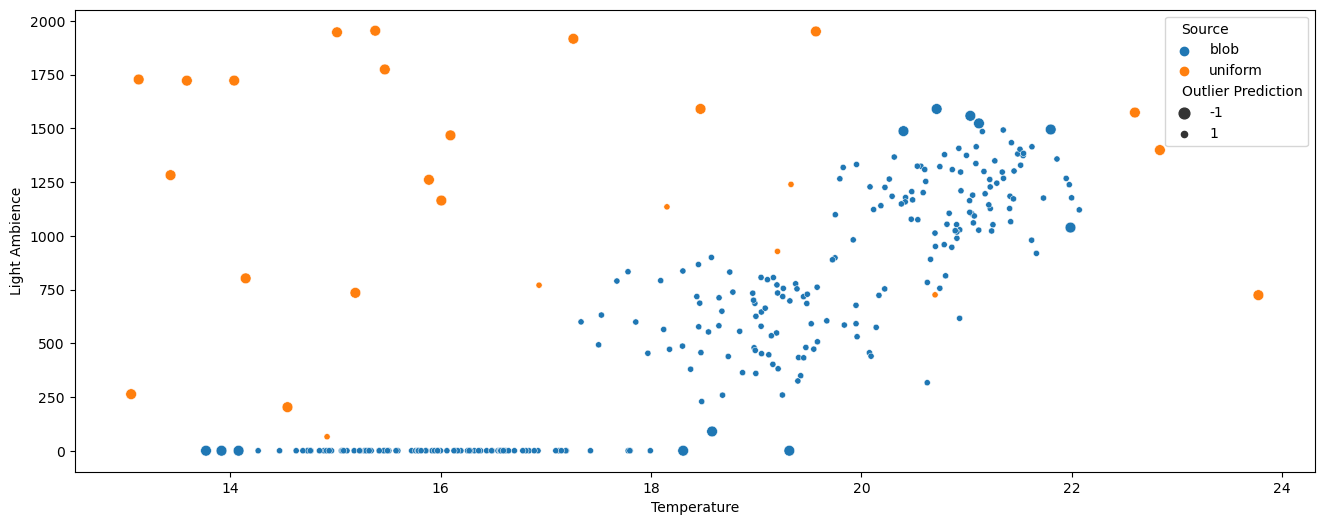

In [16]:
dataset_byoml = generate_dataset()

byoml_prediction = waylay.byoml.model.predict(MODEL_NAME, dataset_byoml[col_features])

dataset_byoml[col_predict] = byoml_prediction

plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x=col_tmp, y=col_amb, hue=col_src, size=col_predict, sizes=[60,20], data=dataset_byoml
)

## Upload and test with a Data Query

In the example above we created a toy dataset, but in real world use cases, you probably want to use data already available in Waylay. 

Let's simulate that by first uploading 10 weeks of data and then use a dedicated Query to fetch the data.

Uploading the dataset above can also be done using the SDK, we will convert it to a timestamped dataset first:

In [17]:
data_until = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
upload_count= 10 * 7 * 24 

dataset_import = generate_dataset(upload_count)
data_until
index = pd.date_range(end=data_until, periods=upload_count, freq='1H')

dataset_import = dataset_import.set_index(index)
dataset_import

,Temperature,Light Ambience,Source
2023-03-23 01:00:00,20.280899,874.331237,blob
2023-03-23 02:00:00,20.745224,1350.703005,blob
2023-03-23 03:00:00,19.755547,641.007188,blob
2023-03-23 04:00:00,16.037751,0.000000,blob
2023-03-23 05:00:00,16.647032,0.000000,blob
...,...,...,...
2023-05-31 20:00:00,20.134439,674.704322,blob
2023-05-31 21:00:00,21.478784,992.688971,blob
2023-05-31 22:00:00,20.187208,1320.737226,blob
2023-05-31 23:00:00,14.962619,0.000000,blob


Timeseries data in waylay is normally associated with a _resource_. It is the entity that contains descriptions of the device (or other source) of IoT events. 

The `waylay.resources.resource` actions let you manage these _resources.


In [18]:
resource_id = f'byoml-{MODEL_NAME}'
waylay.resources.resource.update(resource_id, body={
    'id': resource_id,
    'name': resource_id
})

{'id': 'byoml-tutorial-2023-06-01-0781',
 'name': 'byoml-tutorial-2023-06-01-0781'}

Now let's import this data into Waylay using the `waylay.timeseries.etl_tool` for bulk timeseries uploads.

In [19]:
etl_import = waylay.timeseries.etl_tool.prepare_import(
    dataset_import,
    name= f'byoml-{MODEL_NAME}',
    resource=resource_id,
    timestamp_timezone='UTC'
)
etl_import = waylay.timeseries.etl_tool.initiate_import(etl_import)

100%|█| 3.00/3.00 [00:00<00:00, 50.5series/s]


Importing data this way is an asynchronous process. 

Use `waylay.timeseries.etl_tool.check_import` to check on
the progress before continuing.

In [20]:
## temporary workaround for gateway migration, otherwise check_import fails when using the etl service api
waylay.etl.set_root_url('https://etl.waylay.io/api')

In [21]:
from IPython.display import HTML
from tenacity import Retrying, stop_after_attempt, wait_fixed

for attempt in Retrying(stop=stop_after_attempt(10),wait=wait_fixed(10)):
    with attempt:

        import_job = waylay.timeseries.etl_tool.check_import(etl_import)

        display(HTML(import_job.to_html()))

        if import_job.status != 'done':
            raise TryAgain

RetryError: RetryError[<Future at 0x7f843ad89690 state=finished raised NameError>]

In [30]:
import_job = waylay.timeseries.etl_tool.check_import(etl_import)

In [31]:
from IPython.display import HTML

import_job = waylay.timeseries.etl_tool.check_import(etl_import)
display(HTML(import_job.to_html()))

Once an ETL upload has been completed, you can remove the import files with `timeseries.etl_tool.cleanup_import`.

In [32]:
import_job = waylay.timeseries.etl_tool.cleanup_import(etl_import)
display(HTML(import_job.to_html()))

After uploading the dataset, we can use it in a Query. 

Let's query the last 7 days directly: 

In [33]:
query_name=f"query-{resource_id}"
query = {
    "window": "P7D",
    "data" : [
        {'resource': resource_id, 'metric': column}
        for column in col_features
    ]
}
waylay.queries.query.execute(body=query)

resource                  byoml-tutorial-2023-06-01-0781               
metric                                       Temperature Light Ambience
timestamp                                                              
2023-05-25 11:00:00+00:00                      21.538738    1190.836255
2023-05-25 12:00:00+00:00                      16.487355       0.000000
2023-05-25 13:00:00+00:00                      20.889821    1319.704416
2023-05-25 14:00:00+00:00                      22.102606    1331.664802
2023-05-25 15:00:00+00:00                      15.408776       0.000000
...                                                  ...            ...
2023-05-31 20:00:00+00:00                      20.134439     674.704322
2023-05-31 21:00:00+00:00                      21.478784     992.688971
2023-05-31 22:00:00+00:00                      20.187208    1320.737226
2023-05-31 23:00:00+00:00                      14.962619       0.000000
2023-06-01 00:00:00+00:00                      21.732284     871.336916

[158 rows x 2 columns]

We'll save this query under a name, so that we can reuse it. 

In [34]:
query_name=f"query-{resource_id}"
waylay.queries.query.create(body={
    'name': query_name, 'query': query
})
waylay.queries.query.get(query_name)

{'window': 'P7D',
 'data': [{'metric': 'Temperature',
   'resource': 'byoml-tutorial-2023-06-01-0781'},
  {'metric': 'Light Ambience', 'resource': 'byoml-tutorial-2023-06-01-0781'}]}

You can still override the properties of the query when executing them with `waylay.analytics.query.data`.

<AxesSubplot:xlabel='timestamp'>

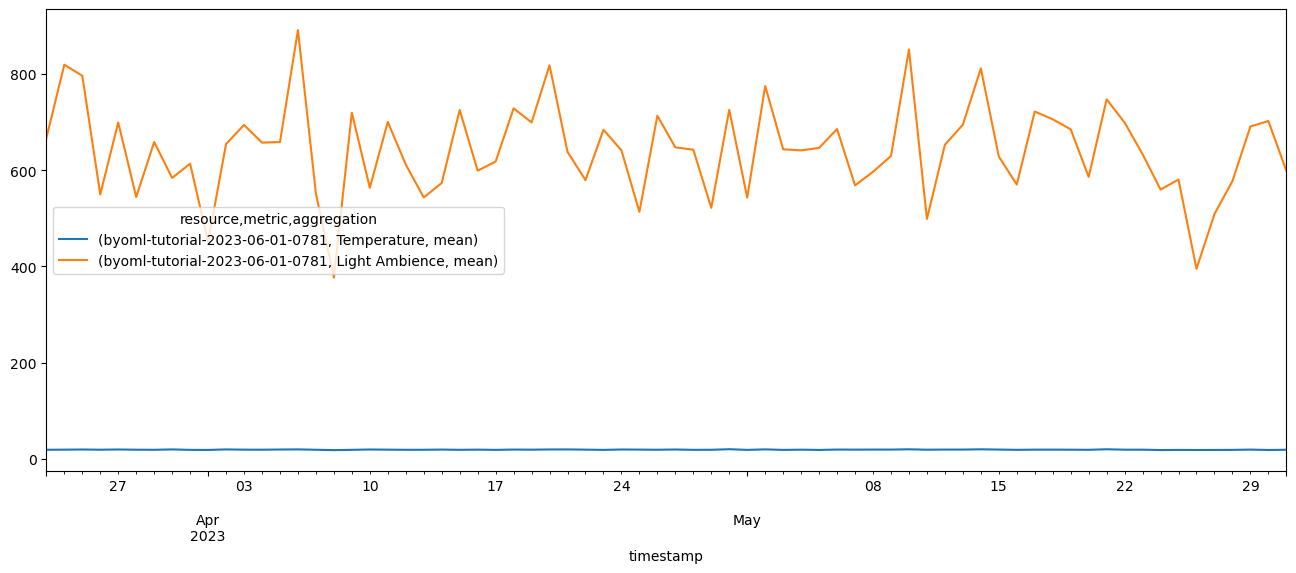

In [35]:
waylay.queries.query.execute(
    query_name, params={ 'window': 'P70D', 'aggregation': 'mean', 'freq': 'P1D' }
).plot(figsize=(16, 6))

Let's use this to select a new training set and validation set for our model

In [36]:
data_previous_month = waylay.queries.query.execute(query_name, params={'window': 'P30D', 'until': '-P30D'})
data_previous_month

resource                  byoml-tutorial-2023-06-01-0781               
metric                                       Temperature Light Ambience
timestamp                                                              
2023-04-02 11:00:00+00:00                      21.047245    1142.452795
2023-04-02 12:00:00+00:00                      19.057907    1683.387742
2023-04-02 13:00:00+00:00                      15.471034       0.000000
2023-04-02 14:00:00+00:00                      18.510734     427.891284
2023-04-02 15:00:00+00:00                      18.494809       0.000000
...                                                  ...            ...
2023-05-02 06:00:00+00:00                      21.323608    1377.493848
2023-05-02 07:00:00+00:00                      20.688605    1415.906504
2023-05-02 08:00:00+00:00                      16.289850       0.000000
2023-05-02 09:00:00+00:00                      19.287020     420.384101
2023-05-02 10:00:00+00:00                      21.796654    1347.350664

[720 rows x 2 columns]

In [37]:
data_last_week = waylay.queries.query.execute(query_name, params={ 'until': '-P1D' })
data_last_week

resource                  byoml-tutorial-2023-06-01-0781               
metric                                       Temperature Light Ambience
timestamp                                                              
2023-05-24 11:00:00+00:00                      21.657560    1452.801214
2023-05-24 12:00:00+00:00                      21.477315    1297.720386
2023-05-24 13:00:00+00:00                      15.611829       0.000000
2023-05-24 14:00:00+00:00                      15.547100       0.000000
2023-05-24 15:00:00+00:00                      15.963896       0.000000
...                                                  ...            ...
2023-05-31 06:00:00+00:00                      23.399870    1775.889034
2023-05-31 07:00:00+00:00                      19.089180     646.270447
2023-05-31 08:00:00+00:00                      20.107876    1437.413163
2023-05-31 09:00:00+00:00                      19.514243     789.837983
2023-05-31 10:00:00+00:00                      21.683339    1229.440627

[168 rows x 2 columns]

We can now do the same as we did above, but now using data directly from Waylay, which will also help when we make a rule with this model and Query.

In [38]:
model = IsolationForest()
model.fit(data_previous_month)

waylay.byoml.model.replace(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='sklearn', 
    description='isolationforest example'
)

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'isolationforest example',
 'framework': 'sklearn',
 'framework_version': '0.24',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'isolationforest example'},
 'name': 'tutorial-2023-06-01-0781',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '2'}

We can now grab other data to do the validation:

In [39]:
result = waylay.byoml.model.predict(MODEL_NAME, data_last_week)
len(result)

168

In [40]:
data_last_week[col_predict] = waylay.byoml.model.predict(MODEL_NAME, data_last_week)
data_last_week

resource                  byoml-tutorial-2023-06-01-0781                 \
metric                                       Temperature Light Ambience   
timestamp                                                                 
2023-05-24 11:00:00+00:00                      21.657560    1452.801214   
2023-05-24 12:00:00+00:00                      21.477315    1297.720386   
2023-05-24 13:00:00+00:00                      15.611829       0.000000   
2023-05-24 14:00:00+00:00                      15.547100       0.000000   
2023-05-24 15:00:00+00:00                      15.963896       0.000000   
...                                                  ...            ...   
2023-05-31 06:00:00+00:00                      23.399870    1775.889034   
2023-05-31 07:00:00+00:00                      19.089180     646.270447   
2023-05-31 08:00:00+00:00                      20.107876    1437.413163   
2023-05-31 09:00:00+00:00                      19.514243     789.837983   
2023-05-31 10:00:00+00:00                      21.683339    1229.440627   

resource                  Outlier Prediction  
metric                                        
timestamp                                     
2023-05-24 11:00:00+00:00                 -1  
2023-05-24 12:00:00+00:00                  1  
2023-05-24 13:00:00+00:00                  1  
2023-05-24 14:00:00+00:00                  1  
2023-05-24 15:00:00+00:00                  1  
...                                      ...  
2023-05-31 06:00:00+00:00                 -1  
2023-05-31 07:00:00+00:00                  1  
2023-05-31 08:00:00+00:00                 -1  
2023-05-31 09:00:00+00:00                  1  
2023-05-31 10:00:00+00:00                  1  

[168 rows x 3 columns]

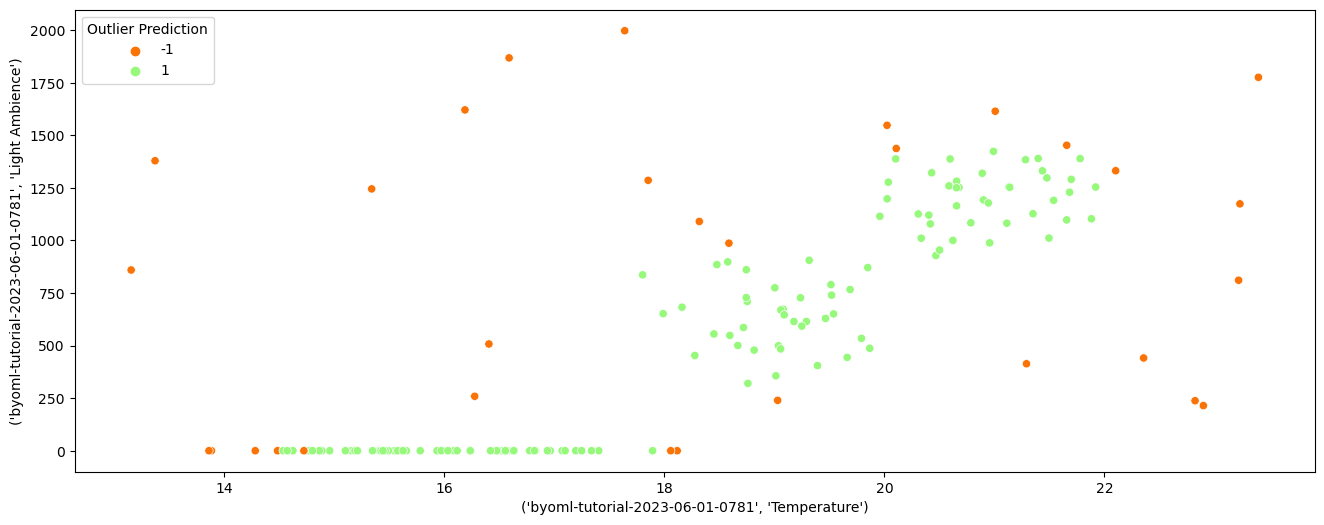

In [41]:
plt.figure(figsize=(16, 6))
cols = data_last_week.columns
ax = sns.scatterplot(
    x=(resource_id, col_tmp),
    y=(resource_id, col_amb),
    hue=col_predict, 
    palette=['xkcd:orange','xkcd:light green'], 
    data=data_last_week
)

#### Cleanup
We delete the entities that were created on the Waylay Platform
* the byoml model
* the query definition
* the waylay resource and its associated data


In [42]:
pd.DataFrame(
    index=['model','resource','query'], 
    data=[MODEL_NAME,resource_id,query_name], 
    columns=['id']
)

,id
model,tutorial-2023-06-01-0781
resource,byoml-tutorial-2023-06-01-0781
query,query-byoml-tutorial-2023-06-01-0781


In [43]:
waylay.queries.query.remove(query_name)
waylay.resources.resource.remove(resource_id)
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model tutorial-2023-06-01-0781: all versions deleted',
 'name': 'tutorial-2023-06-01-0781',
 'versions': ['0.0.2']}